## Accompanying Jupyter Notebook for tutorial:
## "How to query evolutionary relationships among genes with SPARQL"

In [1]:
import sys
!{sys.executable} -m pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
import sys, os, time

# wrapper for executing SPARQL queries
sparql_OMA = SPARQLWrapper("https://sparql.omabrowser.org/sparql")


You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
# sample query for getting pairwise orthologs of a given protein in OMA
query = """select ?protein2  {
   ?cluster a orth:OrthologsCluster.
   ?cluster orth:hasHomologousMember ?node1. 
   ?cluster orth:hasHomologousMember ?node2. 
   ?node2 orth:hasHomologousMember* ?protein2.
   ?node1 orth:hasHomologousMember* ?protein1.
   ?protein1 a orth:Protein.
   ?protein1 dct:identifier \"HUMAN22168\".
   ?protein2 a orth:Protein.
   filter(?node1 != ?node2)}"""

print(query)

select ?protein2  {
   ?cluster a orth:OrthologsCluster.
   ?cluster orth:hasHomologousMember ?node1. 
   ?cluster orth:hasHomologousMember ?node2. 
   ?node2 orth:hasHomologousMember* ?protein2.
   ?node1 orth:hasHomologousMember* ?protein1.
   ?protein1 a orth:Protein.
   ?protein1 dct:identifier "HUMAN22168".
   ?protein2 a orth:Protein.
   filter(?node1 != ?node2)}


In [173]:
sparql_OMA.setQuery(query)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

# print 3 sample results
NUM_EXAMPLES=3
print(str(results_OMA["results"]["bindings"][:NUM_EXAMPLES]))

[{'protein2': {'type': 'uri', 'value': 'https://omabrowser.org/oma/info/GASAC18382'}}, {'protein2': {'type': 'uri', 'value': 'https://omabrowser.org/oma/info/LATCH00597'}}, {'protein2': {'type': 'uri', 'value': 'https://omabrowser.org/oma/info/ORENI11583'}}]


In [181]:
sparql_EBI = SPARQLWrapper("https://www.ebi.ac.uk/rdf/services/sparql")

In [182]:
query_EBI = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dbpedia2: <http://dbpedia.org/property/>
PREFIX dbpedia: <http://dbpedia.org/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX ensembl: <http://rdf.ebi.ac.uk/resource/ensembl/>

SELECT DISTINCT ?gene ?ortholog ?orthologLabel ?name {
?gene sio:SIO_000558 ?ortholog .
?gene obo:RO_0002162 ?taxon .
?gene rdfs:label ?geneLabel .
?ortholog rdfs:label ?orthologLabel .
?ortholog obo:RO_0002162 ?ortholog_taxon .
?ortholog_taxon skos:altLabel ?name
VALUES ?gene {ensembl:ENSG00000139618}
FILTER (?taxon != ?ortholog_taxon)
}
"""


In [184]:
# NOTE: EBI has a problem with their SPARQL endpoint, cannot test in web interface
# seems to be solved in the programmatic query here:
sparql_EBI.setQuery(query_EBI)
sparql_EBI.setReturnFormat(JSON)

results_EBI = sparql_EBI.query().convert()

# print 3 sample results
NUM_EXAMPLES=3
print(str(results_EBI["results"]["bindings"][:NUM_EXAMPLES]))

[{'gene': {'type': 'uri', 'value': 'http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000139618'}, 'ortholog': {'type': 'uri', 'value': 'http://rdf.ebi.ac.uk/resource/ensembl/ENSMUSG00000041147'}, 'orthologLabel': {'type': 'literal', 'value': 'Brca2'}, 'name': {'type': 'literal', 'value': 'house mouse'}}, {'gene': {'type': 'uri', 'value': 'http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000139618'}, 'ortholog': {'type': 'uri', 'value': 'http://rdf.ebi.ac.uk/resource/ensembl/ENSSSCG00000029039'}, 'orthologLabel': {'type': 'literal', 'value': 'BRCA2'}, 'name': {'type': 'literal', 'value': 'pig'}}, {'gene': {'type': 'uri', 'value': 'http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000139618'}, 'ortholog': {'type': 'uri', 'value': 'http://rdf.ebi.ac.uk/resource/ensembl/ENSBTAG00000000988'}, 'orthologLabel': {'type': 'literal', 'value': 'BRCA2'}, 'name': {'type': 'literal', 'value': 'cattle'}}]


In [19]:
sparql_MBGD = SPARQLWrapper("http://sparql.nibb.ac.jp/sparql")

In [175]:
query_MBGD_pairwise = """
PREFIX mbgdr: <http://mbgd.genome.ad.jp/rdf/resource/>
PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>
PREFIX orth: <http://purl.org/net/orth#>

SELECT  ?protein2 ?protein1
WHERE {
values(?protein2){ (<http://purl.uniprot.org/uniprot/B8GA25>)}

?cluster a orth:OrthologsCluster.
?cluster orth:hasHomologous ?node1.
?cluster orth:hasHomologous ?node2.
?node2 orth:hasHomologous* ?gene2.
?node1 orth:hasHomologous* ?gene1.
?gene1 mbgd:uniprot ?protein1.
?gene2 mbgd:uniprot ?protein2.
filter(?node1 != ?node2)
} 
"""


In [179]:
query_MBGD_taxa = """
PREFIX orth: <http://purl.org/net/orth#>
SELECT  ?new_tax
WHERE {
  
values(?x){(<http://mbgd.genome.ad.jp/rdf/resource/cluster/2018-01_default_3927>)}
?x a orth:OrthologsCluster.
?x orth:hasHomologous* ?a .
  filter(contains(STR(?a),"cluster" ))
  BIND(IRI(CONCAT("http://purl.uniprot.org/taxonomy/",STRBEFORE(STRAFTER(STR(?a),"_tax"),"_")) ) as ?new_tax)
  #filter(?new_tax="1079")
  
} limit 10
"""


In [180]:
sparql_MBGD.setQuery(query_MBGD_taxa)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()

# print 3 sample results
NUM_EXAMPLES=3
print(str(results_MBGD["results"]["bindings"][:NUM_EXAMPLES]))

[{'new_tax': {'type': 'uri', 'value': 'http://purl.uniprot.org/taxonomy/'}}, {'new_tax': {'type': 'uri', 'value': 'http://purl.uniprot.org/taxonomy/1079'}}, {'new_tax': {'type': 'uri', 'value': 'http://purl.uniprot.org/taxonomy/35806'}}]


In [174]:
# how to transform SPARQL results into Pandas dataframes

import pandas as pd
# display table of results:
table = []
for entry in results_MBGD["results"]["bindings"]:
    table.append([entry["protein2"]["value"], entry["protein1"]["value"]])
pd.DataFrame(table, columns=["protein2", "protein1"])[:NUM_EXAMPLES]

,protein2,protein1
0,http://purl.uniprot.org/uniprot/A9CEI9,http://purl.uniprot.org/uniprot/A0KKE8
1,http://purl.uniprot.org/uniprot/A9CEI9,http://purl.uniprot.org/uniprot/A9CHY5
2,http://purl.uniprot.org/uniprot/A9CEI9,http://purl.uniprot.org/uniprot/Q7CRN8


In [ ]:
# diff (A, B)

# OMA and MGDB



In [3]:
# histogram OMA - how many entries per taxon? which are the taxa with most entries?
group_by_OMA = """ 
PREFIX obo:<http://purl.obolibrary.org/obo/>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX up: <http://purl.uniprot.org/core/>
select (count(distinct ?protein) as ?count) ?taxon ?name
where {
?protein a orth:Protein.
?protein orth:organism/obo:RO_0002162 ?taxon.
?taxon up:scientificName ?name.
} group by ?taxon ?name order by desc(?count)
"""

In [11]:
# count number of proteins/clusters for each taxonomic range

group_by_taxRange_OMA = """
PREFIX lscr: <http://purl.org/lscr#>
PREFIX orth: <http://purl.org/net/orth#>

SELECT (count(distinct ?cluster) as ?count) ?tax ?name {

?cluster a orth:OrthologsCluster.
?cluster orth:hasTaxonomicRange ?tax.
?tax  orth:taxRange ?name.
} group by ?tax ?name order by desc(?count)
"""

In [12]:
sparql_OMA.setQuery(group_by_taxRange_OMA)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

print("Number of distinct tax range in OMA: "+ str(len(results_OMA["results"]["bindings"])))

Number of distinct tax range in OMA: 975


In [5]:
sparql_OMA.setQuery(group_by_OMA)
sparql_OMA.setReturnFormat(JSON)

results_OMA = sparql_OMA.query().convert()

print("Number of distinct taxa in OMA: "+ str(len(results_OMA["results"]["bindings"])))

Number of distinct taxa in OMA: 2288


In [13]:
# prepare dictionary based on data (either using taxon URI or taxon scientific name)
group_by_results = {}
for entry in results_OMA["results"]["bindings"]:
    #group_by_results[entry["taxon"]["value"]] = int(entry["count"]["value"])
    group_by_results[entry["name"]["value"]] = int(entry["count"]["value"])
 

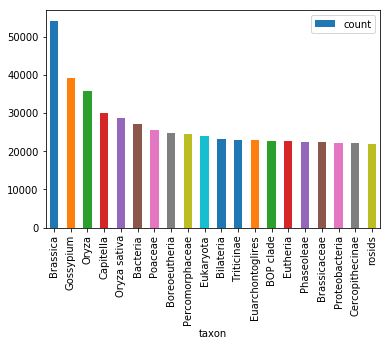

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_groupBy = pd.DataFrame(list(group_by_results.items()), columns=['taxon', 'count'])[:20]
df_groupBy.plot(kind='bar',x='taxon',y='count')

In [ ]:
# histogram MGDB
group_by_MGDB = """ 
PREFIX obo:<http://purl.obolibrary.org/obo/>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX up: <http://purl.uniprot.org/core/>
select (count(distinct ?protein) as ?count) ?taxon ?name
where {
?protein a orth:Protein.
?protein orth:organism/obo:RO_0002162 ?taxon.
?taxon up:scientificName ?name.
} group by ?taxon ?name order by desc(?count)
"""

In [23]:
# PRINT PER SUPERKINGDOM??
group_by_MGDB_superkingdom = """
PREFIX obo:<http://purl.obolibrary.org/obo/>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX mbgdr: <http://mbgd.genome.ad.jp/rdf/resource/>
PREFIX mbgd: <http://purl.jp/bio/11/mbgd#>

select (count(distinct ?gene) as ?count) ?superkingdom
where {
  ?gene a orth:Gene ;
      mbgd:organism ?org .
  ?org mbgd:inSuperkingdom/rdfs:label ?superkingdom .
 }
 group BY ?superkingdom order by desc(?count)
"""

In [ ]:
# and then look at phylum? OPTIONAL {
# ?org mbgd:inPhylum/rdfs:label ?phylum . }

In [24]:
# prepare dictionary based on data (either using taxon URI or taxon scientific name)
sparql_MBGD.setQuery(group_by_MGDB_superkingdom)
sparql_MBGD.setReturnFormat(JSON)

results_MBGD = sparql_MBGD.query().convert()

print("Number of distinct taxa in OMA: "+ str(len(results_MBGD["results"]["bindings"])))
group_by_results = {}
for entry in results_MBGD["results"]["bindings"]:
    group_by_results[entry["superkingdom"]["value"]] = int(entry["count"]["value"])
 

Number of distinct taxa in OMA: 3


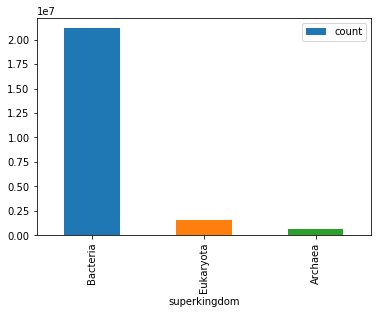

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_groupBy = pd.DataFrame(list(group_by_results.items()), columns=['superkingdom', 'count'])[:20]
df_groupBy.plot(kind='bar',x='superkingdom',y='count')